# Linear Regression

Linear regression fits a straight line through data to predict continuous values. It's the "hello world" of supervised learning. It is simple enough to understand deeply, yet powerful enough to be useful in practice.

**What we'll cover:**
- The model and its parameters
- Cost functions: measuring how wrong we are
- Optimization: analytical solution vs gradient descent
- Extension to multiple features

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## The Problem

Suppose we have data on employees: years of experience and salary. We suspect there's a roughly linear relationship, probably more experience tends to mean higher pay. Our goal is to find the line that best captures this relationship, so we can predict salaries for new data points.

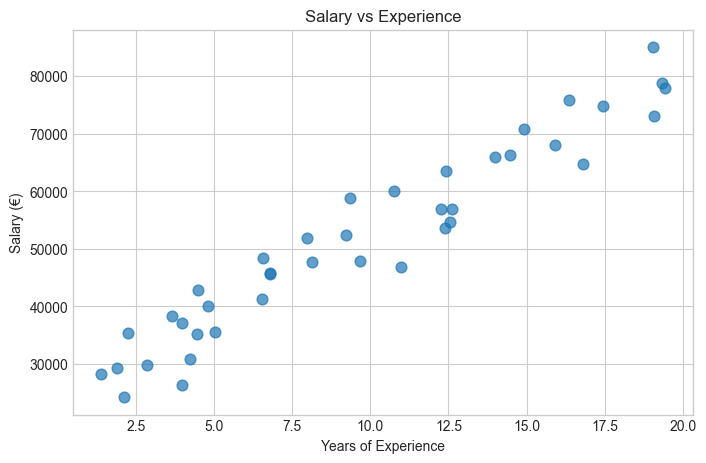

In [41]:
# Generate synthetic salary data
n_samples = 40
years_experience = np.random.uniform(1, 20, n_samples)
salary = 25000 + 2800 * years_experience + np.random.normal(0, 5000, n_samples)

plt.figure(figsize=(8, 5))
plt.scatter(years_experience, salary, alpha=0.7, s=60)
plt.xlabel('Years of Experience')
plt.ylabel('Salary (€)')
plt.title('Salary vs Experience')
plt.show()

## The Linear Model

If you recall it from high school a line in 2D is defined by:

$$F(X) = w_1 \cdot X + w_0$$

Where:
- $w_1$ and $w_0$ are called **weights**
- These values determine how our linear function behaves on different inputs
- **Learning** means determining the right weights!

### Understanding the Weights

**$w_0$ (Intercept):**
- Where the line crosses the y-axis
- Shifts the line up or down

**$w_1$ (Slope):**
- How steep the line is

Let's say the linear fit was associated with weights $w_1 = 5$ and $w_0 = 0.5$. If we changed $w_0$ to $-2$, the line would shift down. If we changed $w_1$ to $8$, the line would become steeper.

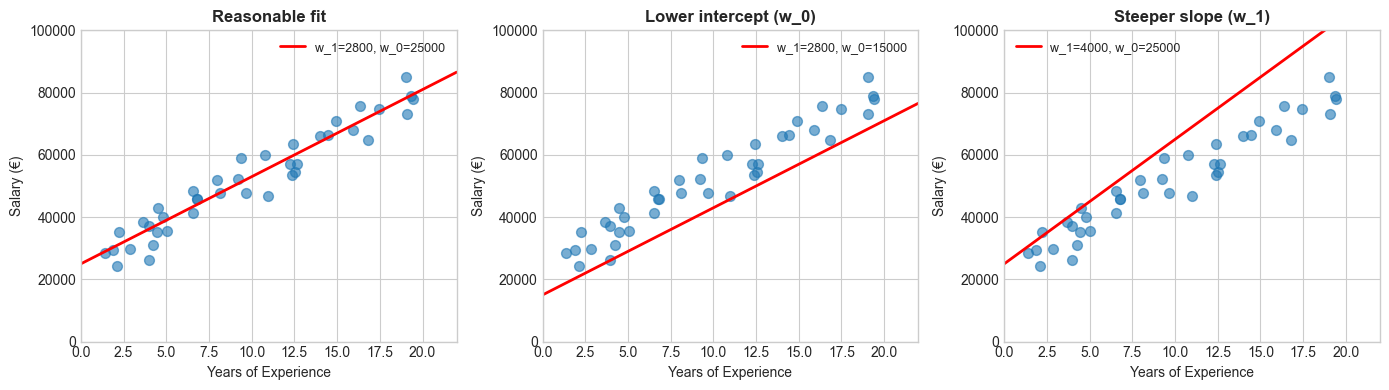

In [42]:
# Visualize how different parameters affect the line
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
x = np.linspace(0, 22, 100)

params = [
    (2800, 25000, 'Reasonable fit'),
    (2800, 15000, 'Lower intercept (w_0)'),
    (4000, 25000, 'Steeper slope (w_1)')
]

for ax, (w1, w0, title) in zip(axes, params):
    ax.scatter(years_experience, salary, alpha=0.6, s=50)
    ax.plot(x, w1 * x + w0, 'r-', linewidth=2, label=f'w_1={w1}, w_0={w0}')
    ax.set_xlabel('Years of Experience')
    ax.set_ylabel('Salary (€)')
    ax.set_title(title, fontweight='bold')
    ax.legend(fontsize=9)
    ax.set_xlim(0, 22)
    ax.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

## Cost Function: Measuring Error

To find the best line, we need a way to quantify "how bad" a given line is. This is what a **cost function** (or loss function) does.

The most common choice for regression is **Mean Squared Error (MSE)**:

$$C(w_0, w_1) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i=1}^{n} (y_i - (w_1 x_i + w_0))^2$$

Where:
- $y_i$ is the actual salary
- $\hat{y}_i = w_1 x_i + w_0$ is our prediction
- $(y_i - \hat{y}_i)$ is called the **residual**

Why squared? Two reasons:
1. Positive and negative errors don't cancel out
2. Large errors are penalized more heavily than small ones

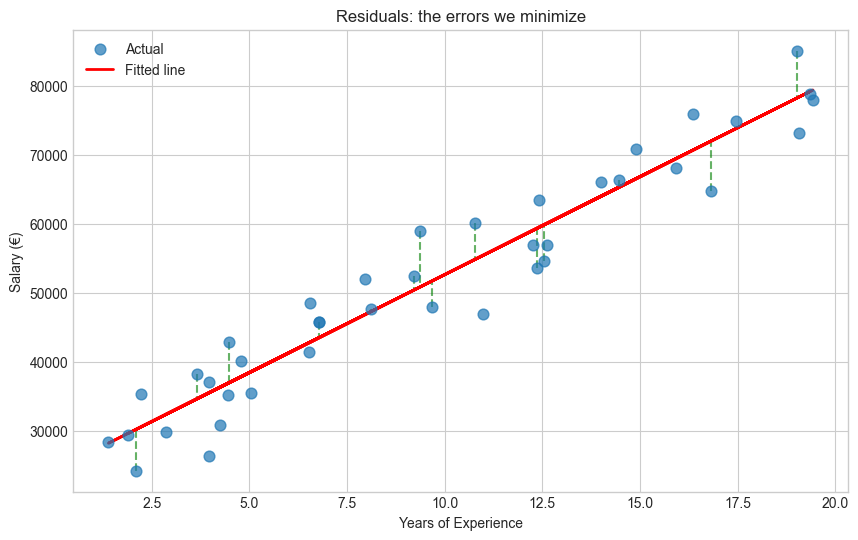

Learned parameters: w₁ = 2835.24 €/year, w₀ = 24267.22 €
Mean Squared Error: 19,347,413
Root MSE: 4,399 € (more interpretable)


In [43]:
# Fit a model and visualize residuals
model = LinearRegression()
X = years_experience.reshape(-1, 1)
model.fit(X, salary)
predictions = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(years_experience, salary, alpha=0.7, s=60, label='Actual', zorder=3)
plt.plot(years_experience, predictions, 'r-', linewidth=2, label='Fitted line', zorder=2)

# Draw residuals
for i in range(0, n_samples, 3):
    plt.plot([years_experience[i], years_experience[i]], 
             [salary[i], predictions[i]], 
             'g--', alpha=0.6, linewidth=1.5, zorder=1)

plt.xlabel('Years of Experience')
plt.ylabel('Salary (€)')
plt.title('Residuals: the errors we minimize')
plt.legend()
plt.show()

mse = mean_squared_error(salary, predictions)
print(f"Learned parameters: w₁ = {model.coef_[0]:.2f} €/year, w₀ = {model.intercept_:.2f} €")
print(f"Mean Squared Error: {mse:,.0f}")
print(f"Root MSE: {np.sqrt(mse):,.0f} € (more interpretable)")

## Finding Optimal Parameters

We have a cost function. Now we need to find the values of $w_0$ and $w_1$ that minimize it. Two approaches:

### Approach 1: Analytical Solution (Normal Equation)

For linear regression with MSE, we can derive a closed-form solution. Taking the gradient of the cost function, setting it to zero, and solving gives us:

$$\mathbf{w} = (X^T X)^{-1} X^T \mathbf{y}$$

This is the **normal equation**. It gives the optimal weights directly with no iteration needed.

**Pros:** Exact solution, fast for small datasets  
**Cons:** Requires matrix inversion, doesn't scale well to very large datasets or many features. Not always possible, slight changes in the cost function or in the dataset dimensions (both in size or number of features) can make it quickly computationally and numerically problematic. 

In [44]:
# Analytical solution from scratch
X_with_bias = np.column_stack([np.ones(n_samples), years_experience])  # Add column of 1s for intercept
y = salary

# Normal equation: w = (X^T X)^(-1) X^T y
w_analytical = np.linalg.inv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y

print(f"Analytical solution:")
print(f"  w₀ (intercept) = {w_analytical[0]:,.2f} €")
print(f"  w₁ (slope) = {w_analytical[1]:,.2f} €/year")
print(f"\nMatches sklearn: w₀ = {model.intercept_:,.2f}, w₁ = {model.coef_[0]:,.2f}")

Analytical solution:
  w₀ (intercept) = 24,267.22 €
  w₁ (slope) = 2,835.24 €/year

Matches sklearn: w₀ = 24,267.22, w₁ = 2,835.24


### Approach 2: Gradient Descent

For more complex models (or very large datasets), we use **gradient descent** which is an iterative optimization algorithm.

The idea: start with random weights, then repeatedly nudge them in the direction that reduces the cost.

**Update rule:**

$$w := w - \alpha \frac{\partial C}{\partial w}$$

Where $\alpha$ is the **learning rate** and it determines how big of a step we take each iteration.

For MSE, the gradients are:

$$\frac{\partial C}{\partial w_1} = -\frac{2}{n} \sum_{i=1}^{n} x_i (y_i - \hat{y}_i)$$

$$\frac{\partial C}{\partial w_0} = -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)$$

## Gradients Derivation

We use the linear model:

$$\hat{y}_i = \mathbf{w}^T \mathbf{x}_i + b$$

and the cost (MSE):

$$J(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

Define the residual:

$$r_i = y_i - \hat{y}_i$$

so:

$$J = \frac{1}{n}\sum_{i=1}^{n} r_i^2$$

### Gradient w.r.t. a single weight $w_j$

Using the chain rule:

$$\frac{\partial J}{\partial w_j}
= \frac{1}{n}\sum_{i=1}^{n} 2r_i \frac{\partial r_i}{\partial w_j}
= \frac{2}{n}\sum_{i=1}^{n} r_i \frac{\partial r_i}{\partial w_j}$$

But:

$$r_i = y_i - (\mathbf{w}^T\mathbf{x}_i + b) \quad\Rightarrow\quad
\frac{\partial r_i}{\partial w_j} = -x_{ij}$$

So:

$$\frac{\partial J}{\partial w_j}
= -\frac{2}{n}\sum_{i=1}^{n} x_{ij}(y_i - \hat{y}_i)$$

### Gradient w.r.t. the bias $b$

Again:

$$\frac{\partial J}{\partial b}
= \frac{2}{n}\sum_{i=1}^{n} r_i \frac{\partial r_i}{\partial b}$$

and since:

$$\frac{\partial r_i}{\partial b} = -1$$

we get:

$$\frac{\partial J}{\partial b}
= -\frac{2}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)$$

### Vector form (all weights at once)

Stack all samples into a matrix $X \in \mathbb{R}^{n \times d}$, weights $\mathbf{w}\in\mathbb{R}^{d}$:

$$\hat{\mathbf{y}} = X\mathbf{w} + b\mathbf{1}$$

Then the gradient is:

$$\nabla_{\mathbf{w}} J = -\frac{2}{n}X^T(\mathbf{y} - \hat{\mathbf{y}})$$

$$\frac{\partial J}{\partial b} = -\frac{2}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)$$


In [45]:
class LinearRegressionGD:
    """Linear regression using gradient descent."""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.w1 = None  # slope
        self.w0 = None  # intercept
        self.cost_history = []
        
    def fit(self, X, y):
        n = len(X)
        
        # Initialize weights to zero
        self.w1 = 0.0
        self.w0 = 0.0
        
        for _ in range(self.n_iter):
            # Predictions with current weights
            y_pred = self.w1 * X + self.w0
            
            # Compute cost (MSE)
            cost = np.mean((y - y_pred) ** 2)
            self.cost_history.append(cost)
            
            # Compute gradients
            dw1 = (-2 / n) * np.sum(X * (y - y_pred))
            dw0 = (-2 / n) * np.sum(y - y_pred)
            
            # Update weights
            self.w1 -= self.lr * dw1
            self.w0 -= self.lr * dw0
            
        return self
    
    def predict(self, X):
        return self.w1 * X + self.w0

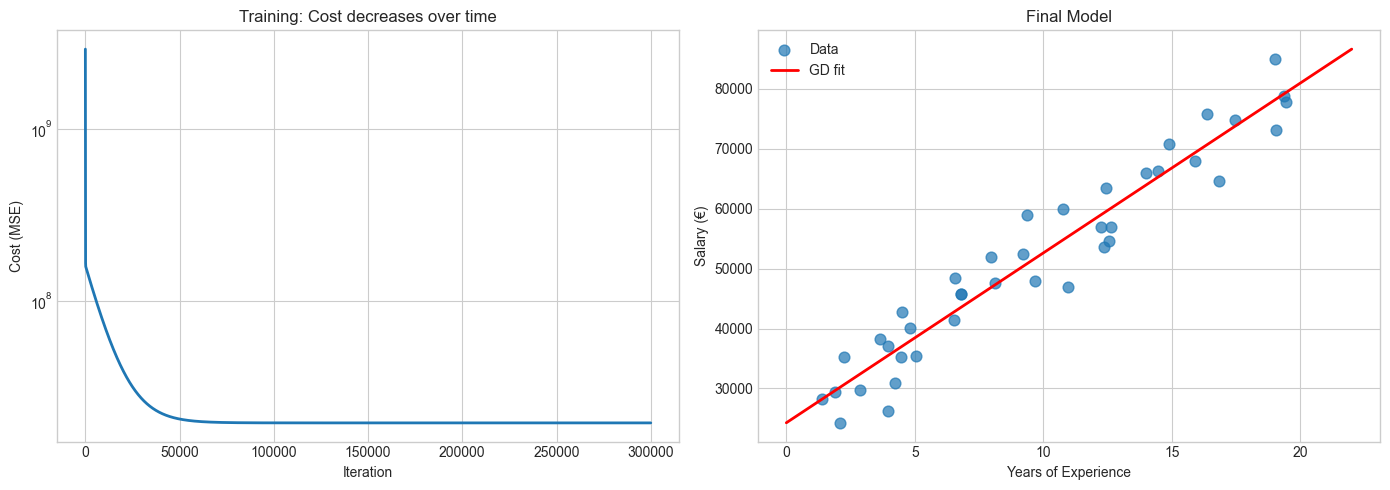

Gradient descent solution:
  w₀ = 24,267.21 €
  w₁ = 2,835.24 €/year

Analytical solution: w₀ = 24,267.22, w₁ = 2,835.24

both methods converge to the same optimum.


In [46]:
# Train with gradient descent
model_gd = LinearRegressionGD(learning_rate=0.0001, n_iterations=300000)
model_gd.fit(years_experience, salary)

# Visualize training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost over iterations
axes[0].plot(model_gd.cost_history, linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost (MSE)')
axes[0].set_title('Training: Cost decreases over time')
axes[0].set_yscale('log')

# Final fit
axes[1].scatter(years_experience, salary, alpha=0.7, s=60, label='Data')
x_line = np.linspace(0, 22, 100)
axes[1].plot(x_line, model_gd.w1 * x_line + model_gd.w0, 'r-', linewidth=2, label='GD fit')
axes[1].set_xlabel('Years of Experience')
axes[1].set_ylabel('Salary (€)')
axes[1].set_title('Final Model')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Gradient descent solution:")
print(f"  w₀ = {model_gd.w0:,.2f} €")
print(f"  w₁ = {model_gd.w1:,.2f} €/year")
print(f"\nAnalytical solution: w₀ = {w_analytical[0]:,.2f}, w₁ = {w_analytical[1]:,.2f}")
print(f"\nboth methods converge to the same optimum.")

### Learning Rate: Getting It Right

The learning rate $\alpha$ is crucial:
- **Too small:** Convergence is painfully slow
- **Too large:** We overshoot the minimum and may never converge

## Multiple Features

Real predictions usually depend on more than one variable. For salary, we might consider:
- Years of experience
- Education level
- Industry
- Location

The model generalizes naturally:

$$f(\mathbf{x}) = w_0 + w_1 x_1 + w_2 x_2 + ... + w_d x_d = w_0 + \mathbf{w}^T \mathbf{x}$$

Same idea, but here we're just fitting a hyperplane instead of a line. The cost function and optimization methods remain identical.

In [48]:
# Multi-feature example
n = 100
years_exp = np.random.uniform(1, 20, n)
education_years = np.random.uniform(12, 22, n)  # 12 = high school, 22 = PhD
is_tech = np.random.binomial(1, 0.4, n)  # 40% in tech industry

# True relationship (unknown to the model)
salary_multi = (
    20000 +
    2500 * years_exp +
    1500 * education_years +
    8000 * is_tech +
    np.random.normal(0, 5000, n)
)

# Fit model
X_multi = np.column_stack([years_exp, education_years, is_tech])
model_multi = LinearRegression()
model_multi.fit(X_multi, salary_multi)

print("Multi-feature model:")
print(f"  Intercept (w0): {model_multi.intercept_:,.0f} €")
print(f"  Years of experience (w1): {model_multi.coef_[0]:,.0f} €/year")
print(f"  Education years (w2): {model_multi.coef_[1]:,.0f} €/year")
print(f"  Tech industry (w3): {model_multi.coef_[2]:,.0f} € premium")
print(f"\nMSE : {mean_squared_error(salary_multi, model_multi.predict(X_multi)):.3f}")

Multi-feature model:
  Intercept (w0): 20,717 €
  Years of experience (w1): 2,563 €/year
  Education years (w2): 1,375 €/year
  Tech industry (w3): 8,393 € premium

MSE : 23325608.300


## Summary

| Concept | What it means |
|---------|---------------|
| **Model** | $f(x) = w_1 x + w_0$ (line), or $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + w_0$ (hyperplane) |
| **Parameters** | Weights $w_0, w_1, ..., w_d$ that we learn from data |
| **Cost function** | MSE: $\frac{1}{n} \sum (y_i - \hat{y}_i)^2$ it measures prediction error |
| **Residual** | $y_i - \hat{y}_i$ individual prediction error |
| **Analytical solution** | Normal equation: $\mathbf{w} = (X^T X)^{-1} X^T \mathbf{y}$ |
| **Gradient descent** | Iterative: $w := w - \alpha \nabla C$ |
| **Learning rate** | Step size in gradient descent: too small is slow, too large diverges |

### When to use linear regression

- Linear relationship between features and target  
- Need interpretable coefficients  
- Quick baseline model  
- Continuous target variable  

### When NOT to use linear regression

- Non-linear relationships (try polynomial features, trees, neural nets)  
- Classification problems (use logistic regression)  
- Many outliers (consider robust regression)  